In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

nltk.download('vader_lexicon')
nltk.download('punkt')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Load the Dataset

In [3]:
# Load dataset
file_path = '/content/drive/MyDrive/Reviews.csv'
df = pd.read_csv(file_path)
df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


 Data Exploration and Cleaning

 Basic Dataset Info


In [4]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


,0
Id,0
ProductId,0
UserId,0
ProfileName,26
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


Drop Duplicates / Nulls

In [5]:
df = df.drop_duplicates()
df = df.dropna(subset=['Text'])  # Assuming 'Text' column exists
df.reset_index(drop=True, inplace=True)


Preprocessing Text

Clean Review Text

In [6]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)
    return text

df['clean_text'] = df['Text'].apply(clean_text)
df[['Text', 'clean_text']].head()


,Text,clean_text
0,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...
2,This is a confection that has been around a fe...,this is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...,great taffy at a great price there was a wide...


VADER Sentiment Analysis

Run VADER

In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    score = vader.polarity_scores(text)
    compound = score['compound']
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['vader_sentiment'] = df['clean_text'].apply(get_vader_sentiment)
df[['clean_text', 'vader_sentiment']].head()


,clean_text,vader_sentiment
0,i have bought several of the vitality canned d...,Positive
1,product arrived labeled as jumbo salted peanut...,Negative
2,this is a confection that has been around a fe...,Positive
3,if you are looking for the secret ingredient i...,Positive
4,great taffy at a great price there was a wide...,Positive


RoBERTa Sentiment Analysis

 Load RoBERTa Model

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


RoBERTa Inference with Truncation

In [10]:
def get_roberta_sentiment(text):
    encoded_input = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512  # Max length for RoBERTa
    )
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    labels = ['Negative', 'Neutral', 'Positive']
    return labels[np.argmax(scores)]

# Apply on a smaller sample first to test
sample_df = df.sample(100, random_state=42).copy()
sample_df['roberta_sentiment'] = sample_df['clean_text'].apply(get_roberta_sentiment)
sample_df[['clean_text', 'vader_sentiment', 'roberta_sentiment']].head()



,clean_text,vader_sentiment,roberta_sentiment
165256,having tried a couple of other brands of glute...,Positive,Positive
231465,my cat loves these treats if ever i cant find ...,Positive,Positive
427827,a little less than i expected it tends to hav...,Positive,Neutral
433954,first there was frosted miniwheats in original...,Positive,Positive
70260,and i want to congratulate the graphic artist ...,Positive,Positive


Visualizations – Sentiment Distribution

VADER Sentiment Distribution

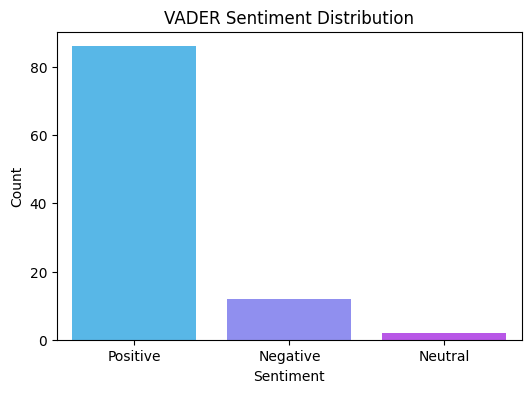

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(data=sample_df, x='vader_sentiment', palette='cool')
plt.title("VADER Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


RoBERTa Sentiment Distribution

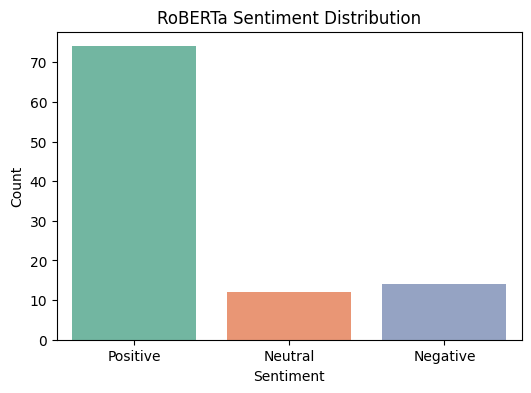

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(data=sample_df, x='roberta_sentiment', palette='Set2')
plt.title("RoBERTa Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


Compare Both Models

Side-by-Side Sentiment Match

In [13]:
comparison = sample_df[['vader_sentiment', 'roberta_sentiment']]
match_percent = (comparison['vader_sentiment'] == comparison['roberta_sentiment']).mean() * 100
print(f"VADER and RoBERTa agree on {match_percent:.2f}% of the samples.")


VADER and RoBERTa agree on 84.00% of the samples.


 WordClouds for Positive and Negative Reviews

Word Cloud Function

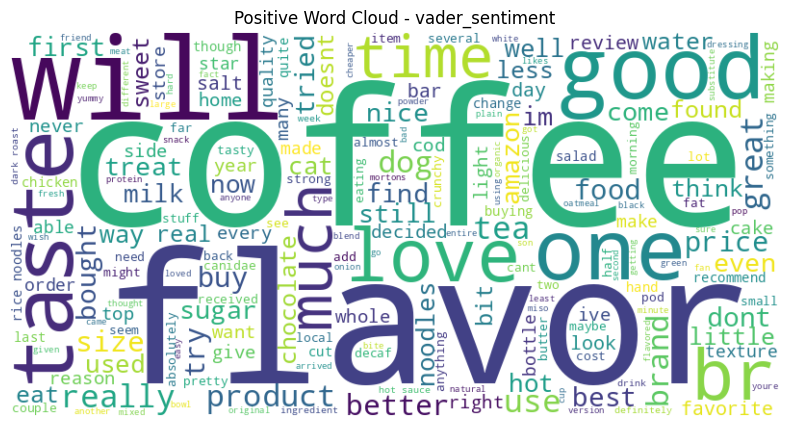

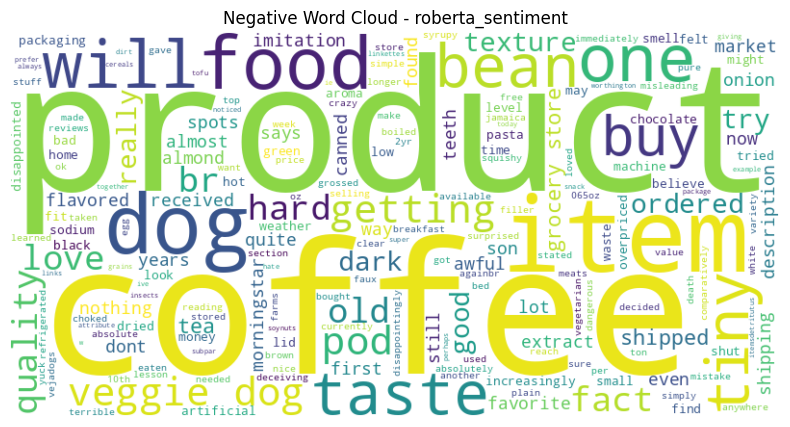

In [14]:
from wordcloud import WordCloud

def plot_wordcloud(sentiment_label, model='vader_sentiment'):
    text = " ".join(sample_df[sample_df[model] == sentiment_label]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"{sentiment_label} Word Cloud - {model}")
    plt.show()

# Example usage
plot_wordcloud('Positive', 'vader_sentiment')
plot_wordcloud('Negative', 'roberta_sentiment')


In [15]:
# Display final analysis
print("Insights Summary:")
print(f"- Total samples used: {len(sample_df)}")
print(f"- VADER vs RoBERTa agreement: {match_percent:.2f}%")
print("- RoBERTa generally performs better for complex or sarcastic reviews.")
print("- VADER is lighter, faster, but less accurate for long texts.")


Insights Summary:
- Total samples used: 100
- VADER vs RoBERTa agreement: 84.00%
- RoBERTa generally performs better for complex or sarcastic reviews.
- VADER is lighter, faster, but less accurate for long texts.


Map Score to Sentiment

In [17]:
# This assumes there's a column called 'Score' with values from 1 to 5
def map_score_to_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

# Add ground truth
sample_df['true_sentiment'] = sample_df['Score'].apply(map_score_to_sentiment)
sample_df[['Score', 'true_sentiment']].head()


,Score,true_sentiment
165256,5,Positive
231465,5,Positive
427827,3,Neutral
433954,2,Negative
70260,5,Positive


Generate Confusion Matrix for VADER and RoBERTa

Evaluate Both Models



VADER Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.53      0.62        17
     Neutral       0.00      0.00      0.00         9
    Positive       0.84      0.97      0.90        74

    accuracy                           0.81       100
   macro avg       0.53      0.50      0.51       100
weighted avg       0.75      0.81      0.77       100



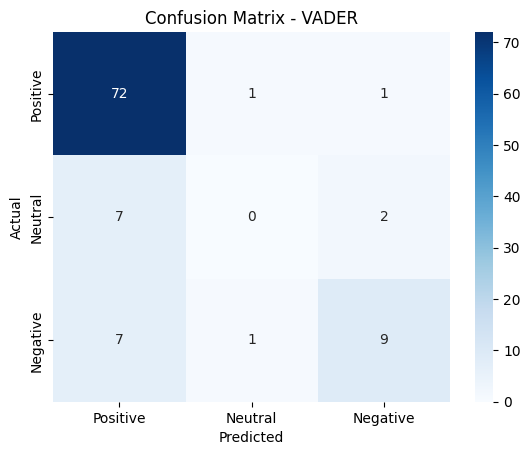

RoBERTa Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.65      0.71        17
     Neutral       0.25      0.33      0.29         9
    Positive       0.93      0.93      0.93        74

    accuracy                           0.83       100
   macro avg       0.66      0.64      0.64       100
weighted avg       0.85      0.83      0.84       100



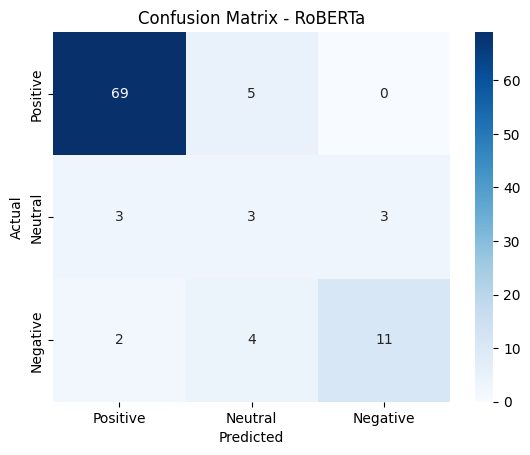

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def plot_conf_matrix(true, pred, title):
    cm = confusion_matrix(true, pred, labels=['Positive', 'Neutral', 'Negative'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Positive', 'Neutral', 'Negative'],
                yticklabels=['Positive', 'Neutral', 'Negative'])
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# For VADER
print("VADER Classification Report:")
print(classification_report(sample_df['true_sentiment'], sample_df['vader_sentiment']))
plot_conf_matrix(sample_df['true_sentiment'], sample_df['vader_sentiment'], "VADER")

# For RoBERTa
print("RoBERTa Classification Report:")
print(classification_report(sample_df['true_sentiment'], sample_df['roberta_sentiment']))
plot_conf_matrix(sample_df['true_sentiment'], sample_df['roberta_sentiment'], "RoBERTa")


 Score vs Sentiment (Bar Plot)

VADER or RoBERTa sentiment labels relate to actual review scores.

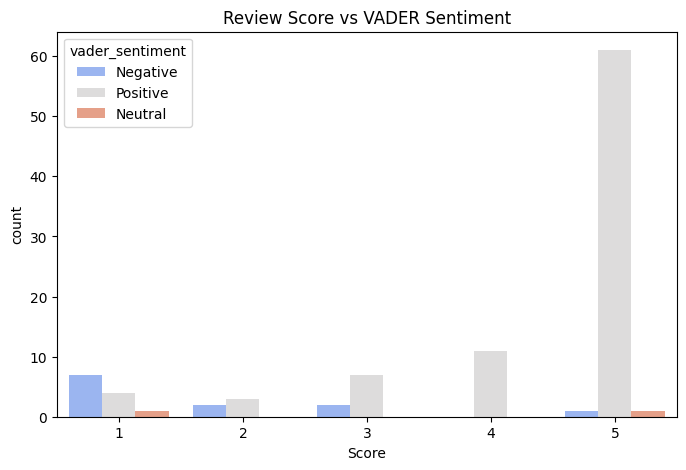

In [19]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Score', hue='vader_sentiment', data=sample_df, palette='coolwarm')
plt.title("Review Score vs VADER Sentiment")
plt.show()


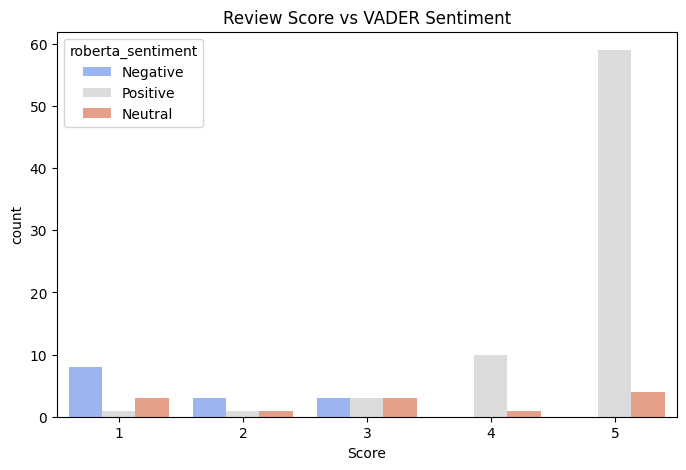

In [20]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Score', hue='roberta_sentiment', data=sample_df, palette='coolwarm')
plt.title("Review Score vs VADER Sentiment")
plt.show()


Sentiment Over Time

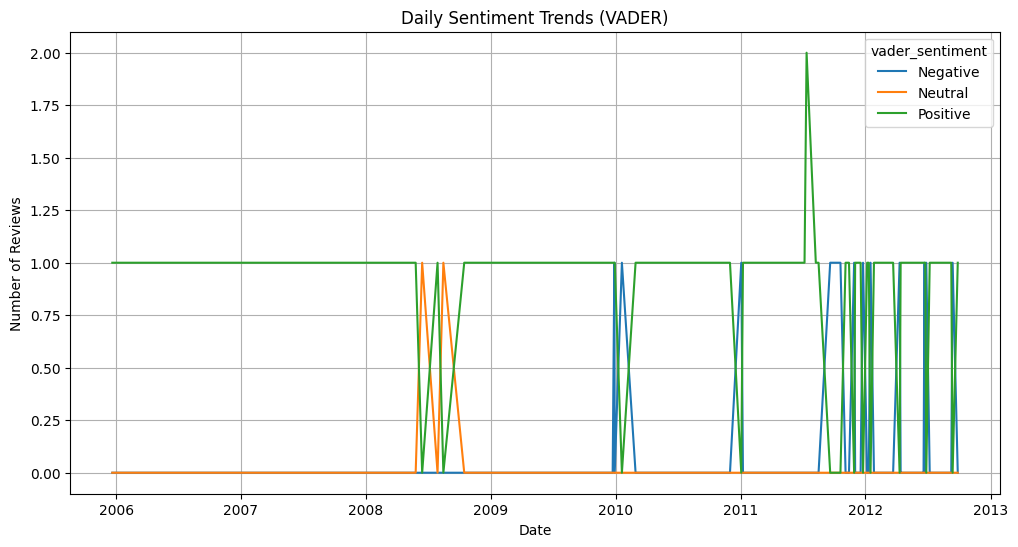

In [21]:
# Convert UNIX timestamp if needed
# sample_df['Time'] = pd.to_datetime(sample_df['Time'], unit='s')

sample_df['Date'] = pd.to_datetime(sample_df['Time'], unit='s')
daily_sentiment = sample_df.groupby(sample_df['Date'].dt.date)['vader_sentiment'].value_counts().unstack().fillna(0)

daily_sentiment.plot(kind='line', figsize=(12, 6))
plt.title("Daily Sentiment Trends (VADER)")
plt.ylabel("Number of Reviews")
plt.xlabel("Date")
plt.grid(True)
plt.show()


Agreement Pie Chart Between VADER and RoBERTa

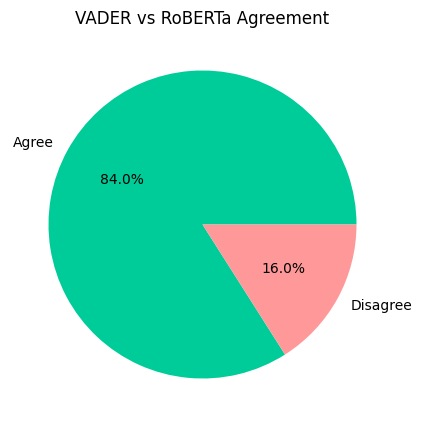

In [22]:
agree = sample_df['vader_sentiment'] == sample_df['roberta_sentiment']
labels = ['Agree', 'Disagree']
sizes = [agree.sum(), (~agree).sum()]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#00cc99', '#ff9999'])
plt.title("VADER vs RoBERTa Agreement")
plt.show()


Most Frequent Words in Each Sentiment (Bar Plot)